In [177]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from PIL import Image

In [178]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [179]:
def load_data():
    train_set = h5py.File('c:/Users/bouse/Desktop/Programmation/Python/GitHub/Projects/Neural-network-from-scratch/archive/train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_set["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_set["train_set_y"][:])

    test_set = h5py.File('c:/Users/bouse/Desktop/Programmation/Python/GitHub/Projects/Neural-network-from-scratch/archive/test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_set["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_set["test_set_y"][:]) # your test set labels

    classes = np.array(test_set['list_classes'][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [180]:
train_x_orig, Y_train, test_x_orig, Y_test, classes = load_data()

y = 0. It's a non-cat picture.


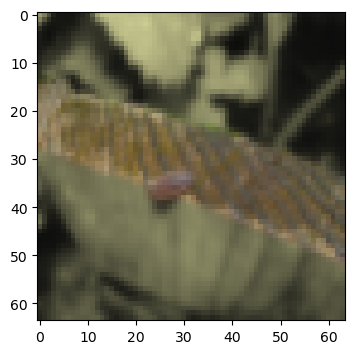

In [181]:
index = 12
plt.imshow(train_x_orig[index])
print ("y = " + str(Y_train[0,index]) + ". It's a " + classes[Y_train[0,index]].decode("utf-8") +  " picture.")

In [182]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(Y_train.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(Y_test.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [183]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
X_train = train_x_flatten/255.
X_test = test_x_flatten/255.

print ("train_x's shape: " + str(X_train.shape))
print ("test_x's shape: " + str(X_test.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [184]:
def init_params(layer_dims):
    
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [185]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = (Z)
    return A, cache

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = (Z)
    return A, cache

def tanh(Z):
    A = np.tanh(Z)
    cache = (Z)
    return A, cache

In [186]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)

    return Z, cache

In [187]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'sigmoid' : 
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [188]:
def forward_prop(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A

        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

In [189]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    logprobs = np.multiply(np.log(AL), Y)
    cost = -1/m * np.sum(logprobs + (1-Y) * np.log(1-AL))

    cost = np.squeeze(cost) 

    return cost

In [190]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [191]:
def tanh_backward(dA, cache):
    Z = cache

    A = np.tanh(Z)

    dZ = dA * (1 - A**2)
    
    return dZ

In [192]:
def relu_backward(dA, cache):
    Z = cache
    
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [193]:
def sigmoid_backward(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [194]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [195]:
def back_prob(AL, Y, caches):

    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [196]:
def update_params(params, grads, alpha):

    parameters = copy.deepcopy(params)

    L = len(parameters) // 2

    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - alpha * grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - alpha * grads["db" + str(l+1)]
    
    return parameters

In [197]:
def nn_model(X, Y, layer_dims, iterations, alpha):

    np.random.seed(1)

    costs = []

    parameters = init_params(layer_dims)

    for i in range(iterations):
        AL, caches = forward_prop(X, parameters)

        cost = compute_cost(AL, Y)

        costs.append(cost)

        grads = back_prob(AL, Y, caches)

        parameters = update_params(parameters, grads, alpha)

        if i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters, cost, costs

In [198]:
def accuracy(X, Y, parameters):
    m = X.shape[1]

    AL, caches = forward_prop(X, parameters)
    predictions = (AL > 0.5)

    accuracy = np.sum(predictions == Y) / m

    return accuracy

In [199]:
def predict(X, parameters):
    m = X.shape[1]

    AL, caches = forward_prop(X, parameters)
    prediction = (AL > 0.5)

    return prediction

In [200]:
layer_dims = [12288, 20, 7, 5, 1]

parameters, cost, costs= nn_model(X_train, Y_train, layer_dims, 3000, 0.0075)
print("cost at the end", cost)

train_set_accuracy = accuracy(X_train, Y_train, parameters)
print(f'accuracy of the model on the training set : {train_set_accuracy * 100:.2f}%')

test_set_accuracy = accuracy(X_test, Y_test, parameters)
print(f'accuracy of the model on the test set : {test_set_accuracy * 100:.2f}%')

Cost after iteration 0: 1.208125
Cost after iteration 1000: 0.637406
Cost after iteration 2000: 0.539141
cost at the end 0.08237974441376017
accuracy of the model on the training set : 100.00%
accuracy of the model on the test set : 80.00%


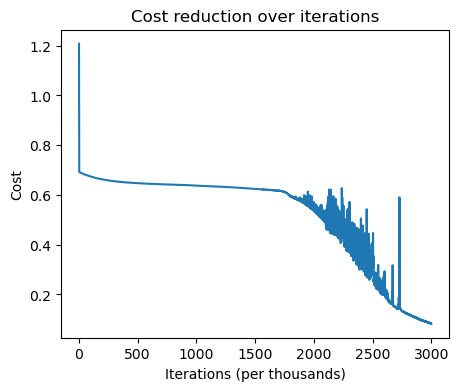

In [201]:
# Plot the cost
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per thousands)')
plt.title('Cost reduction over iterations')
plt.show()

y = 1, your L-layer model predicts a "cat" picture.


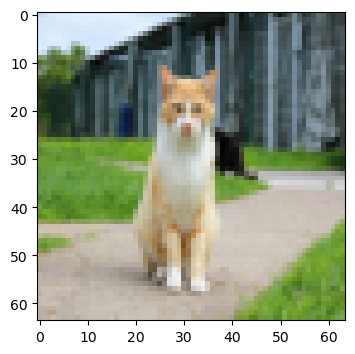

In [202]:
image_to_predict = "db3.jpg"
my_label_y = [1]

fname = "images/" + image_to_predict
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

predicted_image = int(predict(image, parameters))

print ("y = " + str(np.squeeze(predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(predicted_image)),].decode("utf-8") +  "\" picture.")